open short
34495000248 B 12 141700000 R 12 0
34495000248 S 100 823210000 R -100 0
short close
34498000248 S 12 141670000 R 0 -53680000
34498000248 B 10 824010000 R -90 -53680000
34559805047 B 90 824010000 A 0 -53230000
open short
34587000248 B 6 141790000 R 6 -53230000
34603859247 S 36 823240000 A -36 -53050000
34603859247 S 56 823240000 A -92 -53050000
34603859447 S 8 823240000 A -100 -85250000
short close
34604000248 S 6 141800000 R 0 -87750000
34604000248 B 100 823940000 R 0 -87750000
open long
34607000248 S 6 141800000 R -6 -87750000
34607000248 B 100 823930000 R 100 -87750000
long close
34609000248 B 6 141820000 R 0 -119310000
34611241847 S 100 823300000 A 0 -87810000
open long
34620000248 S 2 141770000 R -2 -87810000
34643728247 B 1 823900000 A 1 -87770000
34644100647 B 99 823900000 A 100 -88070000
long close
34649000248 B 2 141770000 R 0 -98090000
34652328847 S 34 823300000 A 66 -69590000
34652328847 S 66 823300000 A 0 -69590000
open short
34655000248 B 1 141770000 R 1 -69590000

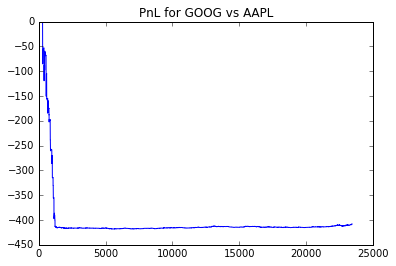

CPU times: user 80.1 ms, sys: 13.6 ms, total: 93.7 ms
Wall time: 1min 12s


In [56]:
%%time
import sys
from simulator import (
    Simulator, string_to_micro, micro_to_time,
    BUY, SELL, SHORT, EXCH_INET,
    BOOK_DEPTH1_PRICE, ORDER_EVENTS,
    )
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AR


class Ave_Lee(object):
    def __init__(self, session, date, tickers, start_time, end_time):
        self.session = session
        self.date = date
        self.tickers = tickers
        self.ticker1 = self.tickers[0]
        self.ticker2 = self.tickers[1]
        self.start_time = start_time
        self.end_time = end_time
        self.interval = string_to_micro("1s")
        self.state = 'NULL'
        
        # variables for BUY or SELL
        self.side1 = 0
        self.side2 = 0
        # variables for order size
        self.order_size1 = 100
        self.order_size2 = 1
        # variables to keep track of total shares bought/sold and the corresponding amount of money
        self.buy_shares1 = 0
        self.buy_dollars = 0
        self.sell_shares1 = 0
        self.sell_dollars = 0
        self.buy_shares2 = 0
        self.sell_shares2 = 0
        # minimum increment for an order
        self.tick_size = 10000
        
        # variables to keep track of how many positions we have opened and closed respectively
        self.open_longs = 0
        self.open_shorts = 0
        self.close_longs = 0
        self.close_shorts = 0 
        self.runs = 0
        
        # variables used for the fitOU, when to open/close a position and how far we look back
        self.long_open = 1.25 #1.50 #1.25
        self.long_close = 0.40 #0.25 #0.50
        self.short_open = 1.25 #1.50 #1.25;
        self.short_close = 0.40 #0.50 #0.75
        self.training_size = 50
        
        # start timer/ call the start_callback function
        self.session.add_timer(self.start_time, self.start_callback)
        
        # list to store pnl every time we update it
        self.pnl = []
        # dictionary to store time, midprices and the returns each timestep
        self.results = {'time': []}
        for ticker in self.tickers:
            self.results[ticker] = []
            self.results['return {}'.format(ticker)] = []
        
        # subscribe to the tickers of interest, and set the first timer
        for ticker in self.tickers:
            self.session.subscribe_ticker_all_feeds(ticker)
    
    def start_callback(self, time):
        for ticker in self.tickers:
            self.session.subscribe_event(ticker, ORDER_EVENTS, self.event_callback)
        self.session.add_timer(time, self.timer_callback)
        
    
    def event_callback(self, ticker, event_params):
        # call the execution manager whenever we have an execution
        self.process_executions(event_params)
        
    def timer_callback(self, time):
        self.results['time'].append(micro_to_time(time))
        # get the best bid and offer, compute the midmarket
        bid1, ask1 = self.session.get_inside_market(self.ticker1)
        bid2, ask2 = self.session.get_inside_market(self.ticker2)
        # append the midprices
        self.results[self.ticker1].append(self.get_midmarket(self.ticker1) / 1000000.0)
        self.results[self.ticker2].append(self.get_midmarket(self.ticker2) / 1000000.0)
        
        # start calculating returns after 1 second
        if time > self.start_time + 10**6:
            self.results['return {}'.format(self.ticker1)].append(np.float(returns(self.results[self.ticker1][-2:])))
            self.results['return {}'.format(self.ticker2)].append(np.float(returns(self.results[self.ticker2][-2:])))
        
        # start collecting signals after training_size * 1 second
        if time > self.start_time + self.training_size * 10**6:
            # collect the last training_size of returns
            returns1 = self.results['return {}'.format(self.ticker1)][-self.training_size:]
            returns2 = self.results['return {}'.format(self.ticker2)][-self.training_size:]
            # regress the returns and fit the residuals, calculate the s-score
            residuals, a,b = regress(returns1,returns2)
            kappa, m, sigma, sigmaeq = fitOU(residuals, self.training_size)
            s = sscore(m, sigmaeq)
            # find current net position (=0: neutral, <0: we are short asset 1, >0: we are long asset 1)
            pos = self.buy_shares1 - self.sell_shares1            
            # feature to check if we have orders at the market before we open a position
            orders = self.session.get_all_orders()
        
            if not orders and b > 0 and kappa > 0:
                if pos == 0:
                    if s < -self.long_open:
                        self.side1 = BUY
                        self.side2 = SELL
                        price1 = ask1['price']# - self.tick_size
                        price2 = bid2['price']# + self.tick_size
                        # make the portfolio self financing by making sure we sell for as much as we buy
                        self.order_size2 = int(b * self.order_size1)
                        self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                        self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                        self.open_longs += 1
                        print("open long")
                    elif s > self.short_open:
                        self.side1 = SELL
                        self.side2 = BUY
                        price1 = bid1['price']# + self.tick_size
                        price2 = ask2['price']# - self.tick_size
                        # make the portfolio self financing by making sure we buy for as much as we sell
                        self.order_size2 = int(b * self.order_size1)
                        self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                        self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                        self.open_shorts += 1
                        print("open short")
                elif pos < 0 and s < self.short_close:
                    self.side1 = BUY
                    self.side2 = SELL
                    price1 = ask1['price']# - self.tick_size
                    price2 = bid2['price']# + self.tick_size
                    self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                    self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                    self.close_shorts += 1
                    print("short close")
                elif pos > 0 and s > -self.long_close:
                    self.side1 = SELL
                    self.side2 = BUY
                    price1 = bid1['price']# + self.tick_size
                    price2 = ask2['price']# - self.tick_size
                    self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                    self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                    self.close_longs += 1
                    print("long close")
        # update pnl every second to see how it evolves over the day            
        pnl = self.get_pnl()
        self.pnl.append(pnl / 1000000.0)
            
        # reset the timer unless we are done 
        if time < self.end_time:
            self.session.add_timer(time + self.interval, self.timer_callback) 
                
            
    def process_executions(self, evp):
        # make sure that we only update if we have executed any orders
        # when we want to add transaction costs we do it in this function
        if 'executed_orders' in evp:
            time = self.session.current_time()
            for ex in evp['executed_orders']:
                order = ex['order']
                side = order['side']
                ticker = order['ticker']
                if ticker == self.ticker1:
                    if side == 'B':
                        self.buy_shares1 += ex['quantity_executed']
                        #self.buy_dollars += ex['quantity_executed'] * ex['price_executed']
                        # buy in midmarker to check if spread is "eating" profits
                        self.buy_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    else:
                        self.sell_shares1 += ex['quantity_executed']
                        #self.sell_dollars += ex['quantity_executed'] * ex['price_executed']
                        # sell in midmarker to check if spread is "eating" profits
                        self.sell_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    pos = self.buy_shares1 - self.sell_shares1
                elif ticker == self.ticker2:
                    if side == 'B':
                        self.buy_shares2 += ex['quantity_executed']
                        #self.buy_dollars += ex['quantity_executed'] * ex['price_executed']
                        # buy in midmarker to check if spread is "eating" profits
                        self.buy_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    else:
                        self.sell_shares2 += ex['quantity_executed']
                        #self.sell_dollars += ex['quantity_executed'] * ex['price_executed']
                        # sell in midmarker to check if spread is "eating" profits
                        self.sell_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    pos = self.buy_shares2 - self.sell_shares2        
                pnl = self.get_pnl()
                print "{0} {1} {quantity_executed} {price_executed} {liquidity} {2} {3}".format(time, side, pos, pnl, **ex)
                

    def get_midmarket(self, ticker):
        bid, ask = self.session.get_inside_market(ticker)
        return (bid['price'] + ask['price']) / 2

    
    def get_pnl(self):
        # mark to the midmarket
        mid1 = self.get_midmarket(self.ticker1)
        mid2 = self.get_midmarket(self.ticker2)
        pnl = self.sell_dollars - self.buy_dollars + (self.buy_shares1 - self.sell_shares1) * mid1 + (self.buy_shares2 - self.sell_shares2) * mid2
        return pnl
    
    
    def end(self):
        print("Total long opens: " + str(self.open_longs))
        print("Total short opens: " + str(self.open_shorts))
        print("Total long closes: " + str(self.close_longs))
        print("Total short closes: " + str(self.close_shorts))
        print('Runs: ' + str(self.runs))
        # plot the pnl
        plot_graph(self.pnl, self.ticker1, self.ticker2)
        #plt.plot(np.asarray(self.pnl))
        #plt.show()
        return self.get_pnl()
    
def regress(returns1,returns2):
    x = np.asarray(returns1).reshape(-1,1)
    y = np.asarray(returns2).reshape(-1,1)
    model = LinearRegression()
    model.fit(x,y)
    a = model.intercept_[0]
    b = model.coef_[0,0]
    residuals = y-model.predict(x)
    return residuals, a,b

def returns(midprices):
    log_return = np.diff(np.log(midprices), axis=-1)
    return log_return #np.diff(midprices, axis=-1)/midprices[:-1]

def fitOU(residual, training_size):
    dt = 1
    ou = np.cumsum(residual)
    model = AR(ou)
    fittedmodel = model.fit(maxlag=1, disp=-1)  
    a = fittedmodel.params[0]
    b = fittedmodel.params[1]
    var =  fittedmodel.sigma2
    if b > 0.0 and b < np.exp(-2.0/training_size):
        kappa = -np.log(b) / dt    
        m = a / (1.0 - np.exp(-kappa * dt))
        sigma = np.sqrt(var * 2.0 * kappa / (1.0 - np.exp(-2.0 * kappa * dt)))
        sigmaeq = np.sqrt(var / (1.0 - np.exp(-2.0 * kappa * dt)));
        return kappa, m, sigma, sigmaeq
    else:
        return -1.0,0,0,0

def sscore(m, sigmaeq):
    if sigmaeq != 0:
        return -m/sigmaeq
    elif m>0:
        return 10000000
    else:
        return -10000000

def plot_graph(pnl, ticker1, ticker2):
    pnl_array = np.asarray(pnl)
    plt.plot(pnl_array)
    plt.title('PnL for {} vs {}'.format(ticker1, ticker2))
    plt.show()
    

date = "20170413"
tickers = ['GOOG', 'AAPL']
start_time = string_to_micro("9:30")
end_time = string_to_micro("16:00")
sim = Simulator(Ave_Lee)
sim.run(date, tickers, use_om=True, start_time=start_time, end_time=end_time)

Investigate parameters  
* Parameters to check:
  * Check large amount of pairs
  * Frequency for checking returns  
  * Order size
  * Check more dates
  * Threshholds
  * Training size
  * Trading hours

In [ ]:
tickers = ['MSFT', 'AMZN', 'AAPL', 'GOOG', 'IBM', 'INTC', 'CSCO', 'TSM', 'ORCL', 'NVDA', 
           'ADBE', 'TXN', 'AVGO', 'CRM', 'QCOM', 'BIDU','MU', 'VMW', 'ITW']

([1.25, 0.5, 0.75], '15s', 100)
ORCL vs NVDA


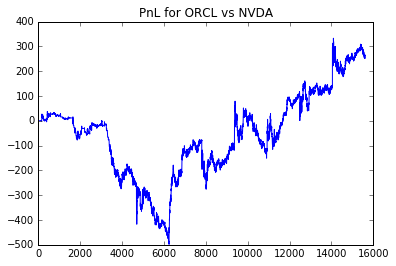

AAPL vs ORCL


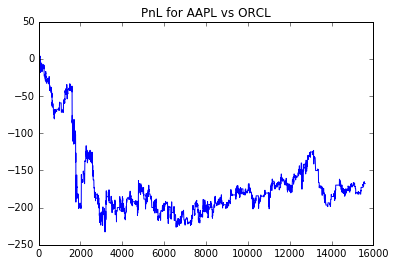

NVDA vs MSFT


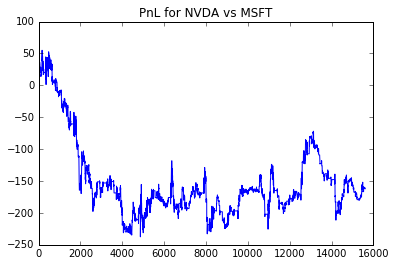

TXN vs AAPL


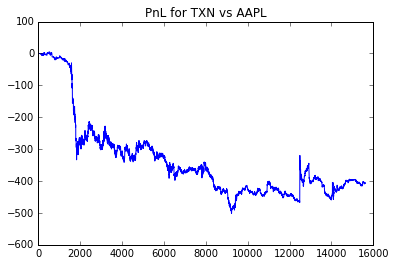

AAPL vs CSCO


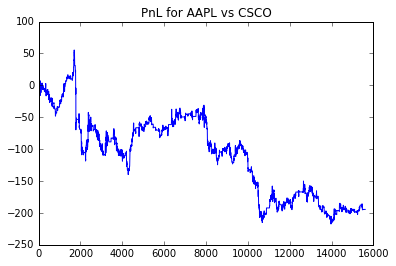

([1.25, 0.5, 0.75], '15s', 200)
ORCL vs NVDA


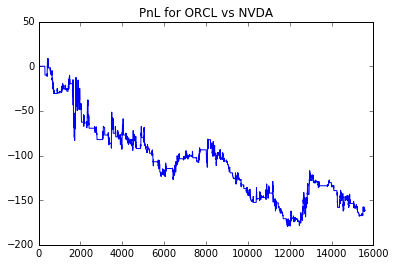

AAPL vs ORCL


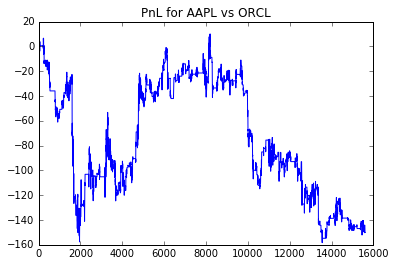

NVDA vs MSFT


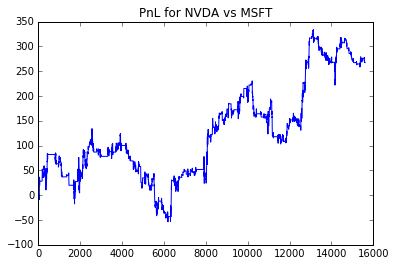

TXN vs AAPL


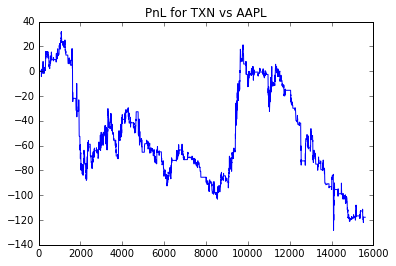

AAPL vs CSCO


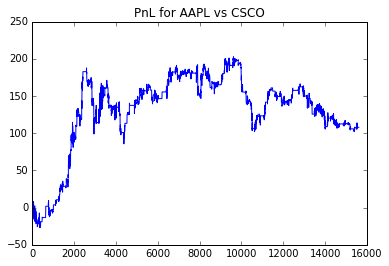

([1.25, 0.5, 0.75], '15s', 300)
ORCL vs NVDA


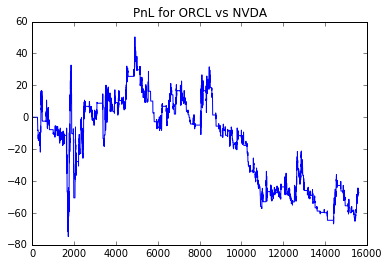

AAPL vs ORCL


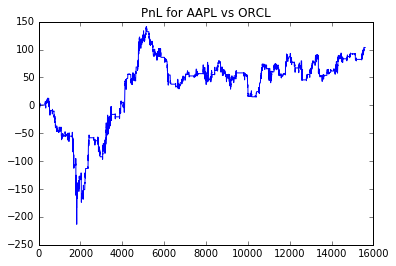

NVDA vs MSFT


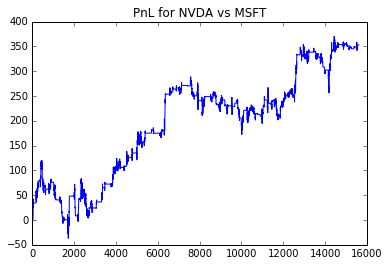

TXN vs AAPL


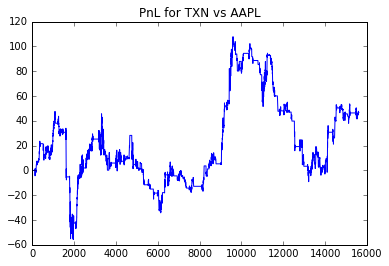

AAPL vs CSCO


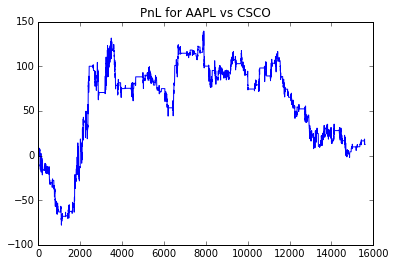

([1.25, 0.5, 0.75], '15s', 400)
ORCL vs NVDA


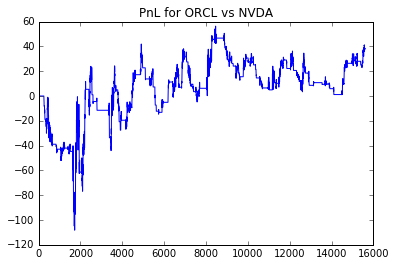

AAPL vs ORCL


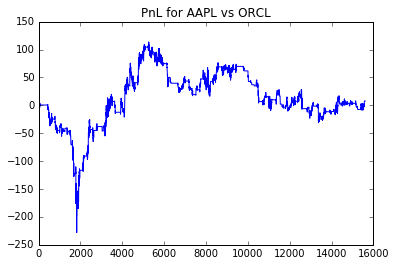

NVDA vs MSFT


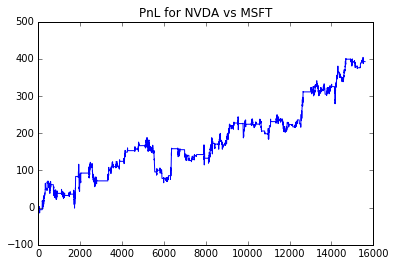

TXN vs AAPL


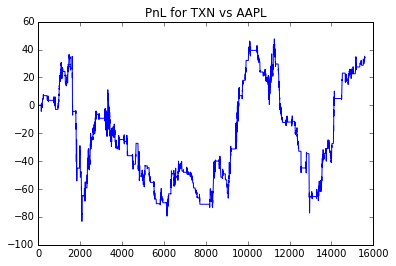

AAPL vs CSCO


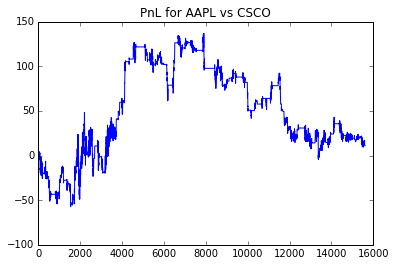

([1.25, 0.5, 0.75], '15s', 500)
ORCL vs NVDA


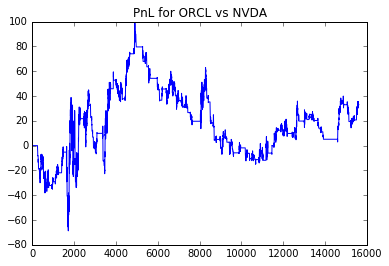

AAPL vs ORCL


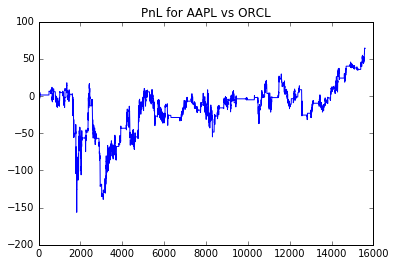

NVDA vs MSFT


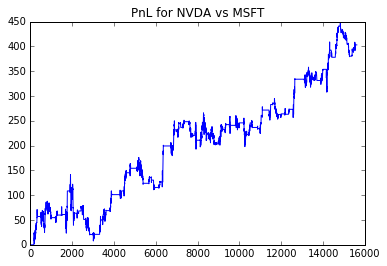

TXN vs AAPL


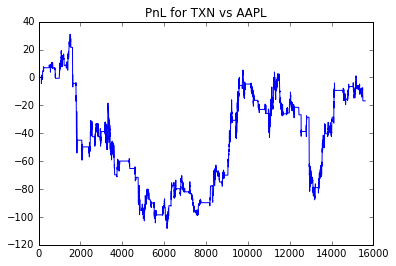

AAPL vs CSCO


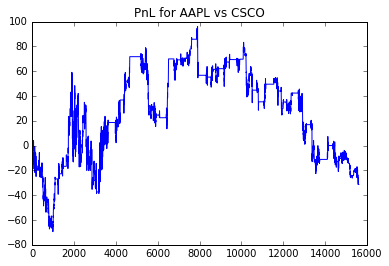

([1.25, 0.5, 0.75], '15s', 600)
ORCL vs NVDA


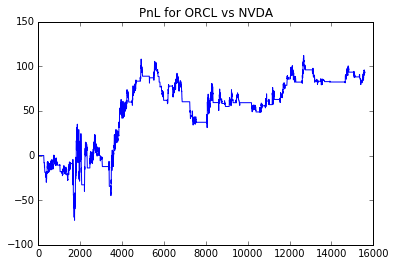

AAPL vs ORCL


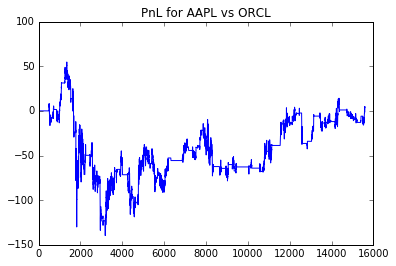

NVDA vs MSFT


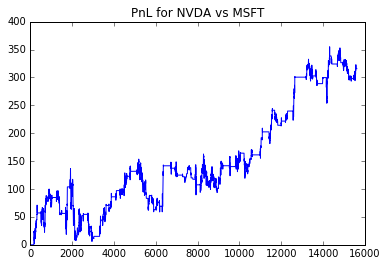

TXN vs AAPL


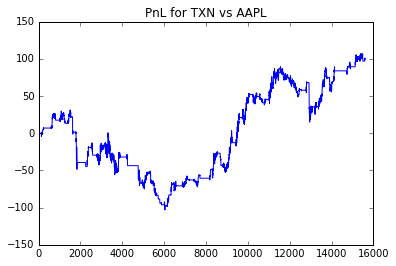

AAPL vs CSCO


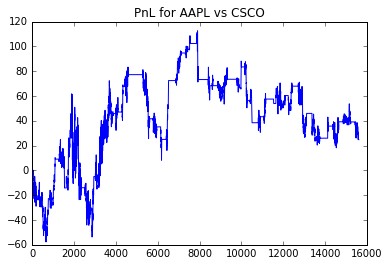

([1.25, 0.5, 0.75], '15s', 700)
ORCL vs NVDA


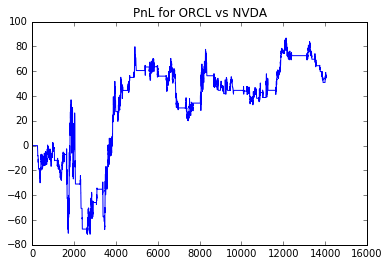

AAPL vs ORCL


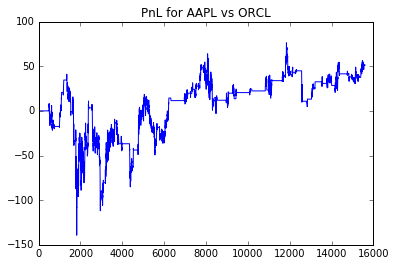

NVDA vs MSFT


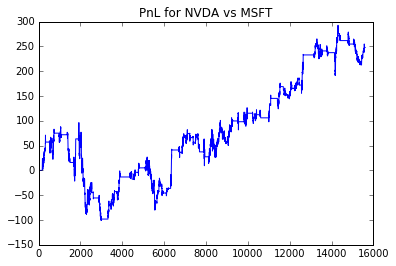

TXN vs AAPL


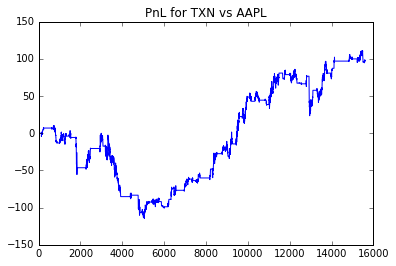

AAPL vs CSCO


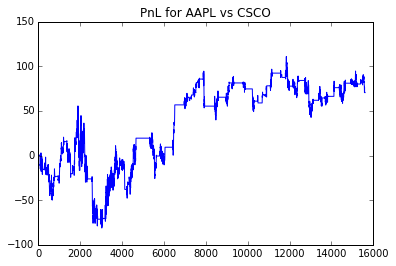

([1.25, 0.5, 0.75], '15s', 800)
ORCL vs NVDA


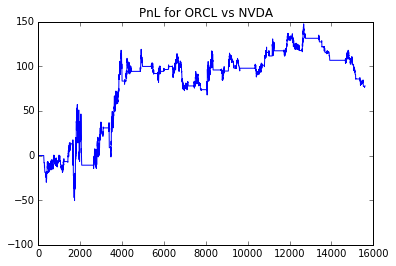

AAPL vs ORCL


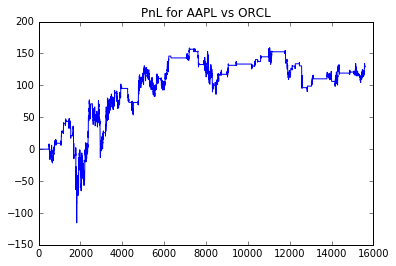

NVDA vs MSFT


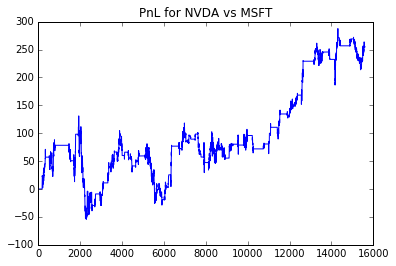

TXN vs AAPL


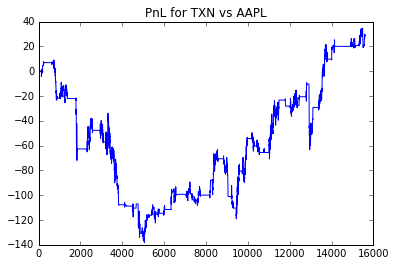

AAPL vs CSCO


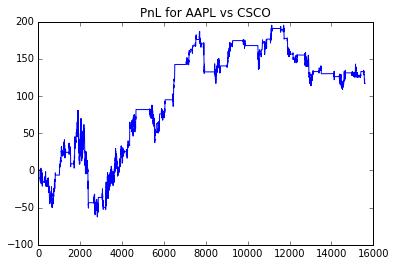

([1.25, 0.5, 0.75], '15s', 900)
ORCL vs NVDA


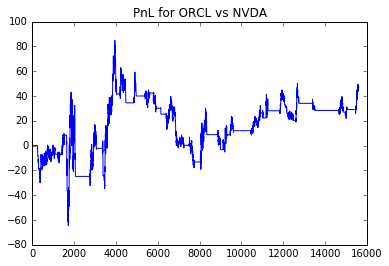

AAPL vs ORCL


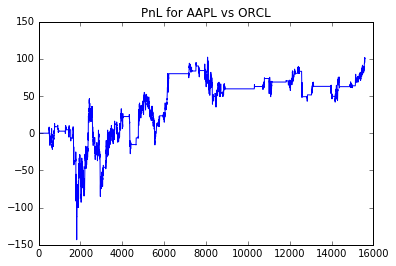

NVDA vs MSFT


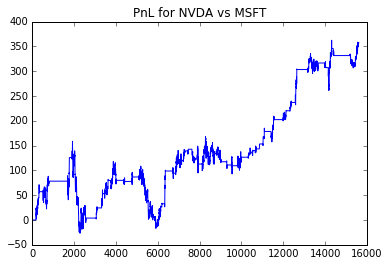

TXN vs AAPL


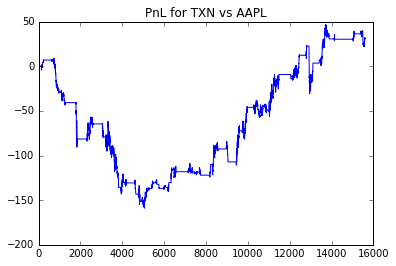

AAPL vs CSCO


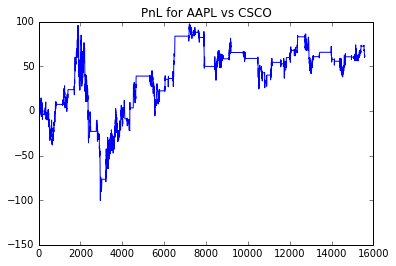

([1.25, 0.5, 0.75], '15s', 1000)
ORCL vs NVDA


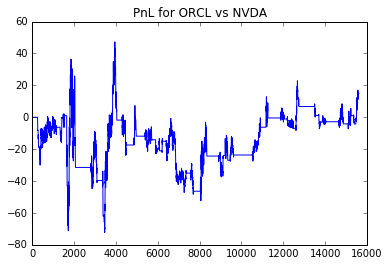

AAPL vs ORCL


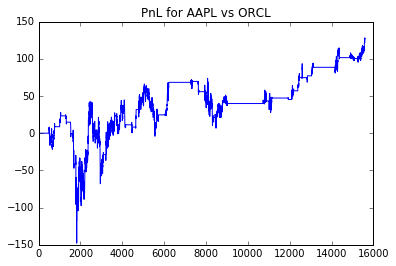

NVDA vs MSFT


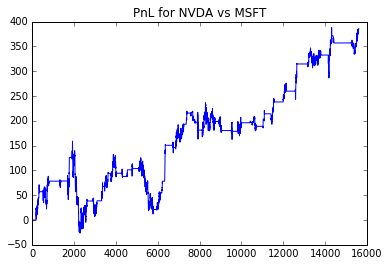

TXN vs AAPL


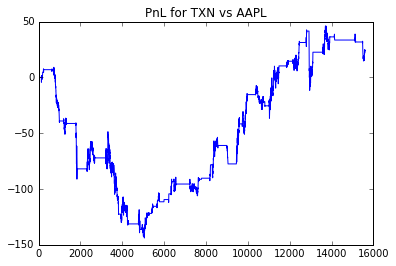

AAPL vs CSCO


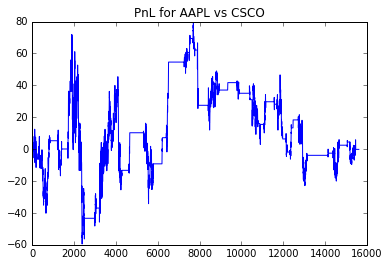

([1.25, 0.5, 0.75], '15s', 1100)
ORCL vs NVDA


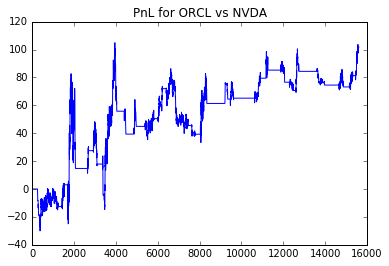

AAPL vs ORCL


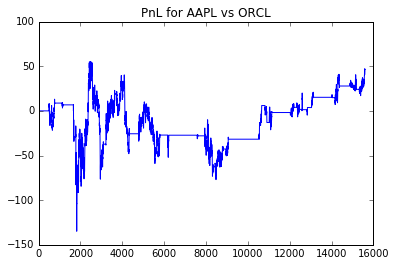

NVDA vs MSFT


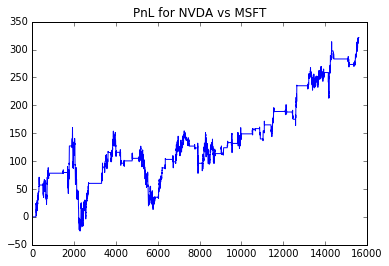

TXN vs AAPL


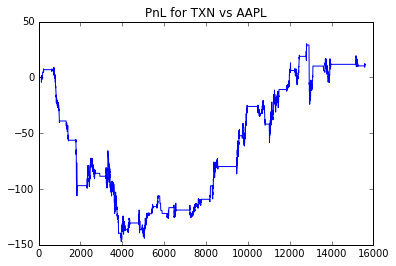

AAPL vs CSCO


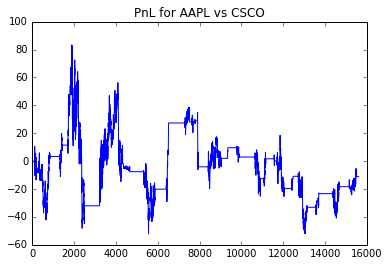

([1.25, 0.5, 0.75], '15s', 1200)
ORCL vs NVDA


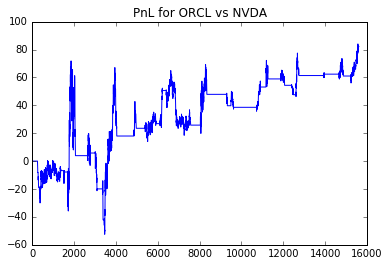

AAPL vs ORCL


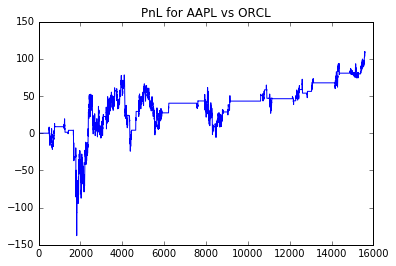

NVDA vs MSFT


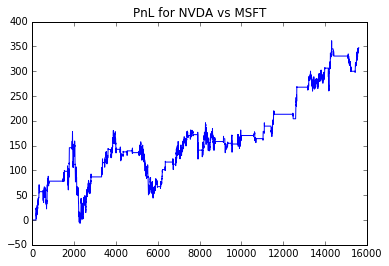

TXN vs AAPL


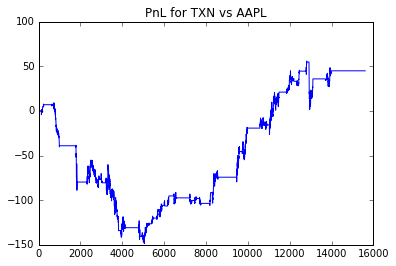

AAPL vs CSCO


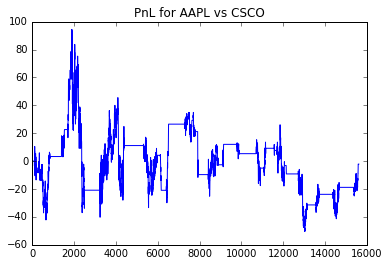

CPU times: user 16.7 s, sys: 1min 10s, total: 1min 26s
Wall time: 7h 24min 30s


In [135]:
%%time
import sys
from simulator import (
    Simulator, string_to_micro, micro_to_time,
    BUY, SELL, SHORT, EXCH_INET,
    BOOK_DEPTH1_PRICE, ORDER_EVENTS,
    )
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AR
from scipy import integrate 
from scipy import optimize


class Ave_Lee(object):
    def __init__(self, session, date, tickers, start_time, end_time, pnl, buy_shares1, buy_dollars, 
                 sell_shares1, sell_dollars, buy_shares2, sell_shares2, threshold, interval, training_size):
        self.session = session
        self.date = date
        self.tickers = tickers
        self.ticker1 = self.tickers[0]
        self.ticker2 = self.tickers[1]
        self.start_time = start_time
        self.end_time = end_time
        self.halt_trading = string_to_micro('5m') # close position 5 minutes before trading ends
        self.interval = string_to_micro(interval)
        self.interval_returns = string_to_micro(interval)
        self.state = 'NULL'
        
        # variables for BUY or SELL
        self.side1 = 0
        self.side2 = 0
        
        # variables for order size
        self.order_size1 = 100
        self.order_size2 = 1
        
        # variables to keep track of total shares bought/sold and the corresponding amount of money
        self.buy_shares1 = buy_shares1
        self.buy_dollars = buy_dollars
        self.sell_shares1 = sell_shares1
        self.sell_dollars = sell_dollars
        self.buy_shares2 = buy_shares2
        self.sell_shares2 = sell_shares2
        
        # variables to keep track of how many positions we have opened and closed respectively
        self.open_longs = 0
        self.open_shorts = 0
        self.close_longs = 0
        self.close_shorts = 0 
        self.runs = 0
        
        # variables used for the fitOU, when to open/close a position and how far we look back
        self.dt = 1
        self.long_open = threshold[0]
        self.long_close = threshold[1]
        self.short_open = threshold[0]
        self.short_close = threshold[2]
        self.training_size = training_size
        
        # start timer/ call the start_callback function
        self.session.add_timer(self.start_time, self.start_callback)
        
        # list to store pnl every time we update it
        self.pnl = pnl
        self.pnl2 = []
        
        # dictionary to store time, midprices and the returns each timestep
        self.results = {'time': []}
        for ticker in self.tickers:
            self.results[ticker] = []
            self.results['return {}'.format(ticker)] = []
        
        # subscribe to the tickers of interest, and set the first timer
        for ticker in self.tickers:
            self.session.subscribe_ticker_all_feeds(ticker)
    
    
    def start_callback(self, time):
        for ticker in self.tickers:
            self.session.subscribe_event(ticker, ORDER_EVENTS, self.event_callback)
        self.session.add_timer(time, self.timer_callback1)
        self.session.add_timer(time, self.timer_callback2)
        
    
    def event_callback(self, ticker, event_params):
        # call the execution manager whenever we have an execution
        self.process_executions(event_params)
        
        
    def timer_callback1(self, time):
        # append the midprices
        self.results[self.ticker1].append(self.get_midmarket(self.ticker1) / 1000000.0)
        self.results[self.ticker2].append(self.get_midmarket(self.ticker2) / 1000000.0)
        
        # start calculating returns after 1 second
        if time > self.start_time + 10**6:
            self.results['return {}'.format(self.ticker1)].append(np.float(returns(self.results[self.ticker1][-2:])))
            self.results['return {}'.format(self.ticker2)].append(np.float(returns(self.results[self.ticker2][-2:])))
        
        # update pnl every second to see how it evolves over the day            
        pnl = self.get_pnl()
        self.pnl.append(pnl / 1000000.0)
        self.pnl2.append(pnl / 1000000.0)
        
        if time < self.end_time:
            self.session.add_timer(time + self.interval_returns, self.timer_callback1)
            
    
    def timer_callback2(self, time):
        self.runs += 1
        self.results['time'].append(micro_to_time(time))
        # get the best bid and offer, compute the midmarket
        bid1, ask1 = self.session.get_inside_market(self.ticker1)
        bid2, ask2 = self.session.get_inside_market(self.ticker2)
        # start collecting signals after training_size * 1 second
        if time > self.start_time + self.halt_trading + self.training_size * 10**6:
            # collect the last training_size of returns
            returns1 = self.results['return {}'.format(self.ticker1)][-self.training_size:]
            returns2 = self.results['return {}'.format(self.ticker2)][-self.training_size:]
            # regress the returns and fit the residuals, calculate the s-score
            residuals, a,b = regress(returns1,returns2)
            kappa, m, sigma, sigmaeq = fitOU(residuals, self.training_size)
            s = sscore(m, sigmaeq)
            # find current net position (=0: neutral, <0: we are short asset 1, >0: we are long asset 1)
            pos = self.buy_shares1 - self.sell_shares1            
            # feature to check if we have orders at the market before we open a position
            orders = self.session.get_all_orders()
        
            residual = residuals[-1]
            
            if not orders and b > 0 and kappa > 0 and sigma > 0 and time < self.end_time - self.halt_trading:
                if pos == 0:
                    if s < -self.long_open:
                        self.side1 = BUY
                        self.side2 = SELL
                        price1 = ask1['price']# - self.tick_size
                        price2 = bid2['price']# + self.tick_size
                        # make the portfolio self financing by making sure we sell for as much as we buy
                        self.order_size2 = int(b * self.order_size1)
                        self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                        self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                        self.open_longs += 1                     
                    elif s > self.short_open:
                        self.side1 = SELL
                        self.side2 = BUY
                        price1 = bid1['price']# + self.tick_size
                        price2 = ask2['price']# - self.tick_size
                        # make the portfolio self financing by making sure we buy for as much as we sell
                        self.order_size2 = int(b * self.order_size1)
                        self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                        self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                        self.open_shorts += 1                    
                elif pos < 0 and s < self.short_close:
                    self.side1 = BUY
                    self.side2 = SELL
                    price1 = ask1['price']# - self.tick_size
                    price2 = bid2['price']# + self.tick_size
                    self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                    self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                    self.close_shorts += 1   
                elif pos > 0 and s > -self.long_close:
                    self.side1 = SELL
                    self.side2 = BUY
                    price1 = bid1['price']# + self.tick_size
                    price2 = ask2['price']# - self.tick_size
                    self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                    self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                    self.close_longs += 1
        
        if time >= self.end_time - self.halt_trading and pos != 0:
            if pos < 0:
                self.side1 = BUY
                self.side2 = SELL
                price1 = ask1['price']# - self.tick_size
                price2 = bid2['price']# + self.tick_size
                self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                self.close_shorts += 1 
            elif pos > 0:
                self.side1 = SELL
                self.side2 = BUY
                price1 = bid1['price']# + self.tick_size
                price2 = ask2['price']# - self.tick_size
                self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                self.close_longs += 1
            
        # reset the timer unless we are done 
        if time < self.end_time:
            self.session.add_timer(time + self.interval, self.timer_callback2)
                
            
    def process_executions(self, evp):
        # make sure that we only update if we have executed any orders
        # when we want to add transaction costs we do it in this function
        if 'executed_orders' in evp:
            time = self.session.current_time()
            for ex in evp['executed_orders']:
                order = ex['order']
                side = order['side']
                ticker = order['ticker']
                if ticker == self.ticker1:
                    if side == 'B':
                        self.buy_shares1 += ex['quantity_executed']
                        #self.buy_dollars += ex['quantity_executed'] * ex['price_executed']
                        # buy in midmarker to check if spread is "eating" profits
                        self.buy_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    else:
                        self.sell_shares1 += ex['quantity_executed']
                        #self.sell_dollars += ex['quantity_executed'] * ex['price_executed']
                        # sell in midmarker to check if spread is "eating" profits
                        self.sell_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    pos = self.buy_shares1 - self.sell_shares1
                elif ticker == self.ticker2:
                    if side == 'B':
                        self.buy_shares2 += ex['quantity_executed']
                        #self.buy_dollars += ex['quantity_executed'] * ex['price_executed']
                        # buy in midmarker to check if spread is "eating" profits
                        self.buy_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    else:
                        self.sell_shares2 += ex['quantity_executed']
                        #self.sell_dollars += ex['quantity_executed'] * ex['price_executed']
                        # sell in midmarker to check if spread is "eating" profits
                        self.sell_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    pos = self.buy_shares2 - self.sell_shares2        
                pnl = self.get_pnl()
                #print "{0} {1} {quantity_executed} {price_executed} {liquidity} {2} {3}".format(time, side, pos, pnl, **ex)
                

    def get_midmarket(self, ticker):
        bid, ask = self.session.get_inside_market(ticker)
        return (bid['price'] + ask['price']) / 2.0
    
    
    def get_pnl(self):
        # mark to the midmarket
        mid1 = self.get_midmarket(self.ticker1)
        mid2 = self.get_midmarket(self.ticker2)
        pnl = self.sell_dollars - self.buy_dollars + (self.buy_shares1 - self.sell_shares1) * mid1 + (self.buy_shares2 - self.sell_shares2) * mid2
        return pnl
    
    
    def end(self):
        plot_graph(self.pnl2, self.ticker1, self.ticker2)
        return (self.pnl, self.buy_shares1, self.buy_dollars, self.sell_shares1, self.sell_dollars, self.buy_shares2, self.sell_shares2)


def regress(returns1,returns2):
    x = np.asarray(returns1).reshape(-1,1)
    y = np.asarray(returns2).reshape(-1,1)
    model = LinearRegression()
    model.fit(x,y)
    a = model.intercept_[0]
    b = model.coef_[0,0]
    residuals = y-model.predict(x)
    return residuals, a,b


def returns(midprices):
    log_return = np.diff(np.log(midprices), axis=-1)
    return log_return #np.diff(midprices, axis=-1)/midprices[:-1]


def fitOU(residual, training_size):
    dt = 1
    ou = np.cumsum(residual)
    model = AR(ou)
    fittedmodel = model.fit(maxlag=1, disp=-1)  
    a = fittedmodel.params[0]
    b = fittedmodel.params[1]
    var =  fittedmodel.sigma2
    if b > 0.0 and b < np.exp(-2.0/training_size):
        kappa = -np.log(b) / dt    
        m = a / (1.0 - np.exp(-kappa * dt))
        sigma = np.sqrt(var * 2.0 * kappa / (1.0 - np.exp(-2.0 * kappa * dt)))
        sigmaeq = np.sqrt(var / (1.0 - np.exp(-2.0 * kappa * dt)));
        return kappa, m, sigma, sigmaeq
    else:
        return -1.0,0,0,0


def sscore(m, sigmaeq):
    if sigmaeq != 0:
        return -m/sigmaeq
    elif m>0:
        return 10000000
    else:
        return -10000000


def plot_graph(pnl, ticker1, ticker2):
    pnl_array = np.asarray(pnl)
    plt.plot(pnl_array)
    plt.title('PnL for {} vs {}'.format(ticker1, ticker2))
    plt.show()
    return None
    

# generalize the process of simulating the algorithm
start_time = string_to_micro("9:30")
end_time = string_to_micro("16:00")

tickers1 = ['ORCL', 'AAPL', 'NVDA', 'TXN', 'AAPL']
tickers2 = ['NVDA', 'ORCL', 'MSFT', 'AAPL', 'CSCO']
#thresholds = [[1.25, 0.5, 0.75], [1.7, 0.35, 0.35]]
#intervals = ['2s', '15s']
#training_sizes = [90, 500, 900]
threshold = [1.25, 0.5, 0.75]
interval = '15s'
training_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

#for threshold in thresholds:
#    for interval in intervals:
for training_size in training_sizes:
    print(threshold, interval, training_size)
    for i in range(len(tickers1)):  
        ticker1 = tickers1[i]
        ticker2 = tickers2[i]
        
        print(str(ticker1) + ' vs ' + str(ticker2))
    
        pnl = []
                
        buy_shares1 = 0
        buy_dollars = 0
        sell_shares1 = 0
        sell_dollars = 0
        buy_shares2 = 0
        sell_shares2 = 0
    
        dates = ['20170410', '20170411', '20170412', '20170413', '20170417', '20170418', '20170419', '20170420',
                    '20170421', '20170424'] # '20170425', '20170426', '20170427', '20170428'
        for date in dates:
            sim = Simulator(Ave_Lee)
            (pnl, buy_shares1, buy_dollars, sell_shares1, sell_dollars, buy_shares2, sell_shares2) = sim.run(date, [ticker1, ticker2], use_om=True, start_time=start_time, end_time=end_time, 
                    pnl=pnl, buy_shares1=buy_shares1, buy_dollars=buy_dollars, sell_shares1=sell_shares1,
                    sell_dollars=sell_dollars, buy_shares2=buy_shares2, sell_shares2=sell_shares2, threshold=threshold,
                    interval=interval, training_size=training_size)
        
        plot_graph(pnl, ticker1, ticker2)
            
            

Parameter tuning over day, PnL based on 10 days of trading, Session 3
* SETTINGS: (2s, 90 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * None
* SETTINGS: (2s, 500 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * NVDA - MSFT 120 dollars, very volatile
* SETTINGS: (2s, 900 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * None
* SETTINGS: (15s, 90 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * None
* SETTINGS: (15s, 500 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * ORCL - NVDA 40 dollars, very volatile
    * AAPL - ORCL 50 dollars, very volatile
    * NVDA - MSFT 400 dollars, volatile in the beginning, then more consistent
* SETTINGS: (15s, 900 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * ORCL - NVDA 50 dollars, very volatile
    * AAPL - ORCL 100 dollars, very volatile
    * NVDA - MSFT 350 dollars, volatile in the beginning, then more consistent
    * TXN - AAPL 25 dollars, long downwards then upwards movement
    * AAPL - CSCO 60 dollars, very volatile
* SETTINGS: (2s, 90 training size; long_open = 1.7, long_close = 0.35, short_open = 1.7, short_close = 0.35)
    * None
* SETTINGS: (2s, 500 training size; long_open = 1.7, long_close = 0.35, short_open = 1.7, short_close = 0.35)
    * None
* SETTINGS: (2s, 900 training size; long_open = 1.7, long_close = 0.35, short_open = 1.7, short_close = 0.35)
    * ORCL - NVDA 250 dollars, up to halfway very volatile, thereafter consistent
    * AAPL - ORCL 80 dollars, very volatile
    * AAPL - CSCO 100 dollars, half volatile, half consistent
* SETTINGS: (15s, 90 training size; long_open = 1.7, long_close = 0.35, short_open = 1.7, short_close = 0.35)
    * None
* SETTINGS: (15s, 500 training size; long_open = 1.7, long_close = 0.35, short_open = 1.7, short_close = 0.35)
    * ORCL - NVDA 100 dollars, consistent first half, then slightly down
    * AAPL - ORCL 70 dollars, consistent but high volatility
    * NVDA - MSFT 250 dollars, consistent after the first half
* SETTINGS: (15s, 900 training size; long_open = 1.7, long_close = 0.35, short_open = 1.7, short_close = 0.35)
    * AAPL - ORCL 200 dollars, consistent first half, then sideways
    
Parameter tuning over night, just tuning training size, PnL based on 10 days of trading, Session 4
* SETTINGS: (15s, variable training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * AAPL - CSCO, peak at training size 800, 120 dollars
    * TXN - AAPL, peak at 600 and 700 training size, 100 dollars
    * NVDA - MSFT, peak at 400, 500 and 1000, 400 dollars
    * AAPL - ORCL, peak at 800 and 1000, 125 dollars
    * ORCL - NVDA, peak at 100, 250 dollars
    * Best training size overall: around 600 - 800
    

Pairs that seem to be making consistent profits:
* SETTINGS: (60s, 300 training size, standard thresholds)
    * ORCL - NVDA 6/9 profits, 1 b/e (60s, 300 training size, standard thresholds)
    * AAPL - ORCL 8/9 profits, 1 b/e (60s, 300 training size, standard thresholds)
    * TSM - VMW 6/9 profits
    * NVDA - MSFT 6/9 profits, 1 b/e
    * TXN - AAPL 6/9 profits
* SETTINGS: (60s, 300 training size; long_open = 1.50, long_close = 0.4, short_open = 1.50, short_close = 0.5)
    * GOOG - IBM 5/9 profits
    * CSCO - TSM 6/9 profits, 1 b/e
    * ORCL - NVDA 6/9 profits, 2 b/e
    * AAPL - ORCL 6/9 profits, 2 b/e
* SETTINGS: (60s, 300 training size; long_open = 1.60, long_close = 0.4, short_open = 1.60, short_close = 0.4)
    * CSCO - TSM 6/9 profits, 1 b/e 
    * ORCL - NVDA 6/9 profits, 1 b/e
    * AAPL - ORCL 5/9 profits, 3 b/e - lot of random movements in final trading
* SETTINGS: (60s, 300 training size; long_open = 1.0, long_close = 0.6, short_open = 1.0, short_close = 0.8)
    * INTC - IBM 5/9 profits
    * AAPL - CSCO 5/9 profits, 1 b/e
    
Parameter tuning over night, PnL based on 10 days of trading
* SETTINGS: (10s, 500 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * NVDA - MSFT 350 dollars - consistently making money
    * AAPL - CSCO 150 dollars - consistently making money
* SETTINGS: (60s, 100 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * ORCL - NVDA 220 dollars - consistently making money
    * AAPL - ORCL 50 dollars - more of a random process
    * NVDA - MSFT 50 dollars - more of a random process
* SETTINGS: (60s, 500 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * ORCL - NVDA 100 dollars - consistently making money but a bit random in the beginning
    * TSM - VMW 20 dollars - very random
    * NVDA - MSFT 350 dollars - consistently making money but a bit random in the beginning
    * TXN - AAPL 120 dollars - consistently making money after a while but starts off losing
* SETTINGS: (10s, 500 training size; long_open = 1.5, long_close = 0.4, short_open = 1.5, short_close = 0.5)
    * NVDA - MSFT 300 dollars - consistently making money although losing some in the beginning
    * TXN - AAPL 60 dollars - more of a random process
    * AAPL - CSCO 125 dollars - pretty consistent
* SETTINGS: (60s, 100 training size; long_open = 1.5, long_close = 0.4, short_open = 1.5, short_close = 0.5)
    * ORCL - NVDA 250 dollars - consistently making money
    * AAPL - ORCL 150 dollars - consistently making money
    * NVDA - MSFT 100 dollars - long downwards and upwards movement
* SETTINGS: (60s, 500 training size; long_open = 1.5, long_close = 0.4, short_open = 1.5, short_close = 0.5)
    * ORCL - NVDA 250 dollars - consistent but strong movements
    * NVDA - MSFT 200 dollars - consistently making money after a while, volatile in the beginning
    * TXN - AAPL 100 dollars - consistently making money after a while, losing in the beginning
    
Parameter tuning over night, PnL based on 10 days of trading, Session 2
* SETTINGS: (60s, 350 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * ORCL - NVDA 100 dollars - consistent after a while, volatile in the beginning
    * AAPL - ORCL 50 dollars - not very consistent, large maximum drawback
    * NVDA - MSFT 300 dollars - consistent after a while, volatile in the beginning
    * TXN - AAPL 50 dollars - strong downwards movement in the beginning, after that strong upwards
* SETTINGS: (60s, 500 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * ORCL - NVDA 100 dollars - consistent after a while, volatile in the beginning
    * NVDA - MSFT 350 dollars - consistent after a while, volatile in the beginning
    * TXN - AAPL 50 dollars - strong downwards movement in the beginning, after that strong upwards
* SETTINGS: (2m, 350 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * NVDA - MSFT 350 dollars - consistent after a while, volatile in the beginning
    * TXN - AAPL 100 dollars - strong downwards movement in the beginning, after that strong upwards
* SETTINGS: (2m, 500 training size; long_open = 1.25, long_close = 0.5, short_open = 1.25, short_close = 0.75)
    * NVDA - MSFT 350 dollars - consistent after a while, volatile in the beginning
    * TXN - AAPL 100 dollars - strong downwards movement in the beginning, after that strong upwards
* SETTINGS: (60s, 350 training size; long_open = 1.5, long_close = 0.4, short_open = 1.5, short_close = 0.5)
    * ORCL - NVDA 100 dollars - strong movements
    * AAPL - ORCL 50 dollars - very volatile
    * NVDA - MSFT 200 dollars - consistent after a while, volatile in the beginning
    * TXN - AAPL 50 dollars - strong downwards movement in the beginning, after that strong upwards
* SETTINGS: (60s, 500 training size; long_open = 1.5, long_close = 0.4, short_open = 1.5, short_close = 0.5)
    * ORCL - NVDA 100 dollars - strong movements
    * NVDA - MSFT 200 dollars - consistent after a while, volatile in the beginning
    * TXN - AAPL 100 dollars - strong downwards movement in the beginning, after that strong upwards
* SETTINGS: (2m, 350 training size; long_open = 1.5, long_close = 0.4, short_open = 1.5, short_close = 0.5)
    * NVDA - MSFT 200 dollars - consistent after a while, volatile in the beginning, stronger movements than before
    * TXN - AAPL 150 dollars - strong downwards movement in the beginning, after that strong upwards, more consistent than before
* SETTINGS: (2m, 500 training size; long_open = 1.5, long_close = 0.4, short_open = 1.5, short_close = 0.5)
    * NVDA - MSFT 200 dollars - consistent after a while, volatile in the beginning, stronger movements than before
    * TXN - AAPL 150 dollars - strong downwards movement in the beginning, after that strong upwards, more consistent than before    
* SETTINGS: (60s, 350 training size; long_open = 1.7, long_close = 0.35, short_open = 1.7, short_close = 0.35)
    * ORCL - NVDA 100 dollars - strong movements
    * AAPL - ORCL 50 dollars - very volatile
    * NVDA - MSFT 150 dollars - consistent after a while, very strong movements
* SETTINGS: (60s, 500 training size; long_open = 1.7, long_close = 0.35, short_open = 1.7, short_close = 0.35)
    * ORCL - NVDA 80 dollars - strong movements
    * NVDA - MSFT 200 dollars - consistent after a while, very strong movements
    * TXN - AAPL 100 dollars - strong downwards movement in the beginning, after that strong upwards
* SETTINGS: (2m, 350 training size; long_open = 1.7, long_close = 0.35, short_open = 1.7, short_close = 0.35)
    * ORCL - NVDA 60 dollars - strong movements
    * TXN - AAPL 150 dollars - strong downwards movement in the beginning, after that strong upwards
* SETTINGS: (2m, 500 training size; long_open = 1.7, long_close = 0.35, short_open = 1.7, short_close = 0.35)
    * ORCL - NVDA 60 dollars - strong movements
    * TXN - AAPL 150 dollars - strong downwards movement in the beginning, after that strong upwards


Metrics to use:
Dollar per trade
Average profit per time in market

ORCL vs NVDA
Last PnL of a: 175.315
Dollar per trade for a: 0.000762239130435
Last PnL of b: 320.91
Dollar per trade for b: 0.00178283333333
Last PnL of c: 246.27
Dollar per trade for c: 0.0015391875
Last PnL of d: 174.235
Dollar per trade for d: 0.00116156666667
Last PnL of e: 112.635
Dollar per trade for e: 0.0007509
Last PnL of f: 71.355
Dollar per trade for f: 0.000548884615385


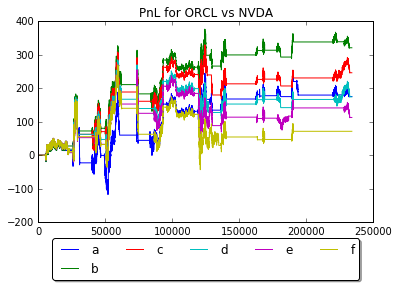

AAPL vs ORCL
Last PnL of a: -20.35
Dollar per trade for a: -7.82692307692e-05
Last PnL of b: 4.605
Dollar per trade for b: 1.91875e-05
Last PnL of c: -3.345
Dollar per trade for c: -1.52045454545e-05
Last PnL of d: 19.265
Dollar per trade for d: 8.75681818182e-05
Last PnL of e: 23.035
Dollar per trade for e: 0.000104704545455
Last PnL of f: -29.125
Dollar per trade for f: -0.000171323529412


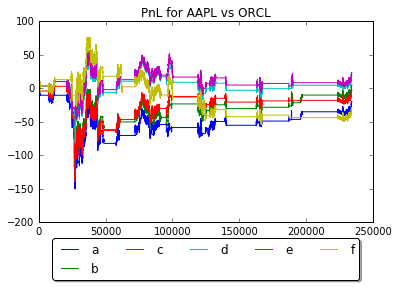

NVDA vs MSFT
Last PnL of a: 304.24
Dollar per trade for a: 0.00095075
Last PnL of b: 351.83
Dollar per trade for b: 0.00125653571429
Last PnL of c: 247.925
Dollar per trade for c: 0.000953557692308
Last PnL of d: 245.715
Dollar per trade for d: 0.00098286
Last PnL of e: 313.115
Dollar per trade for e: 0.00142325
Last PnL of f: 218.66
Dollar per trade for f: 0.00104123809524


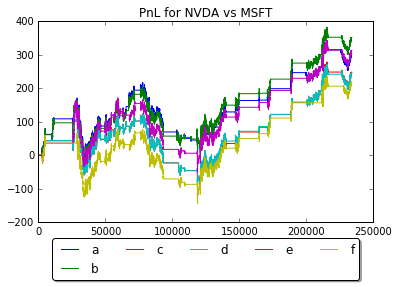

TXN vs AAPL
Last PnL of a: 199.17
Dollar per trade for a: 0.000585794117647
Last PnL of b: 159.465
Dollar per trade for b: 0.000569517857143
Last PnL of c: 197.68
Dollar per trade for c: 0.000760307692308
Last PnL of d: 150.02
Dollar per trade for d: 0.000625083333333
Last PnL of e: 166.27
Dollar per trade for e: 0.00083135
Last PnL of f: 193.58
Dollar per trade for f: 0.00107544444444


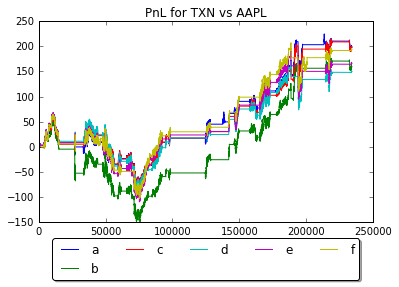

AAPL vs CSCO
Last PnL of a: -152.285
Dollar per trade for a: -0.000564018518519
Last PnL of b: -94.645
Dollar per trade for b: -0.0004115
Last PnL of c: -1.355
Dollar per trade for c: -7.13157894737e-06
Last PnL of d: -39.035
Dollar per trade for d: -0.000229617647059
Last PnL of e: -16.995
Dollar per trade for e: -0.0001133
Last PnL of f: -81.54
Dollar per trade for f: -0.0005436


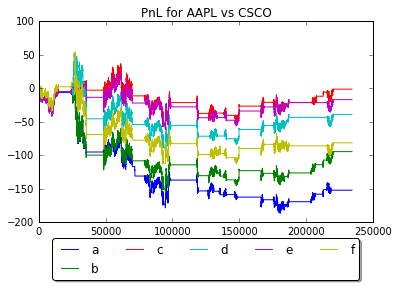

ORCL vs NVDA
Last PnL of g: -459.85
Dollar per trade for g: -0.000867641509434
Last PnL of h: -444.97
Dollar per trade for h: -0.000988822222222
Last PnL of i: -512.575
Dollar per trade for i: -0.00125018292683
Last PnL of j: -276.26
Dollar per trade for j: -0.000746648648649
Last PnL of k: -282.795
Dollar per trade for k: -0.000883734375
Last PnL of l: -322.285
Dollar per trade for l: -0.00111132758621


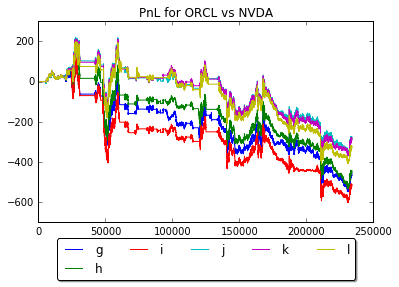

AAPL vs ORCL
Last PnL of g: 119.94
Dollar per trade for g: 0.000214178571429
Last PnL of h: 59.7
Dollar per trade for h: 0.000127021276596
Last PnL of i: 125.455
Dollar per trade for i: 0.0003136375
Last PnL of j: 97.455
Dollar per trade for j: 0.000278442857143
Last PnL of k: 132.115
Dollar per trade for k: 0.000489314814815
Last PnL of l: 111.45
Dollar per trade for l: 0.0004458


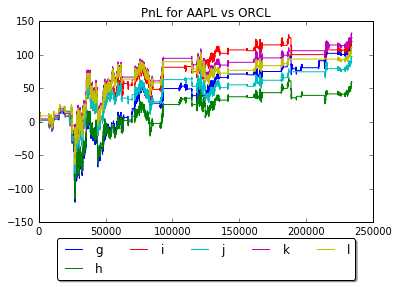

NVDA vs MSFT
Last PnL of g: 385.335
Dollar per trade for g: 0.000713583333333
Last PnL of h: 369.44
Dollar per trade for h: 0.000820977777778
Last PnL of i: 376.645
Dollar per trade for i: 0.000896773809524
Last PnL of j: 263.22
Dollar per trade for j: 0.000731166666667
Last PnL of k: 347.33
Dollar per trade for k: 0.000992371428571
Last PnL of l: 280.66
Dollar per trade for l: 0.00090535483871


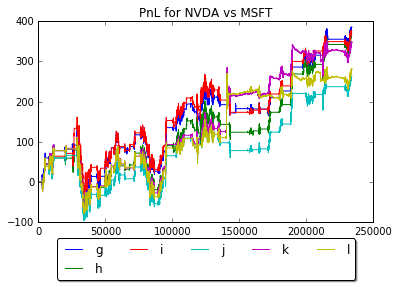

TXN vs AAPL
Last PnL of g: -81.925
Dollar per trade for g: -0.000138855932203
Last PnL of h: -89.665
Dollar per trade for h: -0.00017581372549
Last PnL of i: 26.17
Dollar per trade for i: 5.68913043478e-05
Last PnL of j: 40.43
Dollar per trade for j: 9.4023255814e-05
Last PnL of k: 61.1
Dollar per trade for k: 0.000165135135135
Last PnL of l: 86.0
Dollar per trade for l: 0.000260606060606


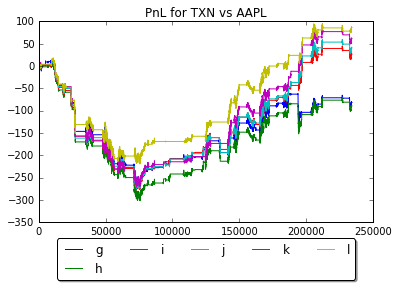

AAPL vs CSCO
Last PnL of g: -73.145
Dollar per trade for g: -0.000123974576271
Last PnL of h: 4.385
Dollar per trade for h: 8.94897959184e-06
Last PnL of i: -2.675
Dollar per trade for i: -6.6875e-06
Last PnL of j: 17.435
Dollar per trade for j: 4.71216216216e-05
Last PnL of k: -13.395
Dollar per trade for k: -4.32096774194e-05
Last PnL of l: 17.195
Dollar per trade for l: 6.36851851852e-05


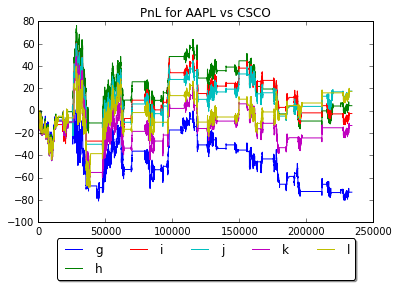

CPU times: user 19.2 s, sys: 22.8 s, total: 42 s
Wall time: 7h 12min 13s


In [45]:
%%time
import sys
from simulator import (
    Simulator, string_to_micro, micro_to_time,
    BUY, SELL, SHORT, EXCH_INET,
    BOOK_DEPTH1_PRICE, ORDER_EVENTS,
    )
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AR
from scipy import integrate 
from scipy import optimize


class Ave_Lee(object):
    def __init__(self, session, date, tickers, start_time, end_time, pnl, buy_shares1, buy_dollars, 
                 sell_shares1, sell_dollars, buy_shares2, sell_shares2, threshold, interval, training_size, trades):
        self.session = session
        self.date = date
        self.tickers = tickers
        self.ticker1 = self.tickers[0]
        self.ticker2 = self.tickers[1]
        self.start_time = start_time
        self.end_time = end_time
        self.halt_trading = string_to_micro('5m') # close position 5 minutes before trading ends
        self.interval = string_to_micro(interval)
        self.interval_pnl = string_to_micro('1s')
        self.state = 'NULL'
        
        # variables for BUY or SELL
        self.side1 = 0
        self.side2 = 0
        
        # variables for order size
        self.order_size1 = 100
        self.order_size2 = 1
        self.buy_size = 10000 * 10**6 # how much we can buy for in each trade
        
        # variables to keep track of total shares bought/sold and the corresponding amount of money
        self.buy_shares1 = buy_shares1
        self.buy_dollars = buy_dollars
        self.sell_shares1 = sell_shares1
        self.sell_dollars = sell_dollars
        self.buy_shares2 = buy_shares2
        self.sell_shares2 = sell_shares2
        
        # variables to keep track of how many positions we have opened and closed respectively
        self.trades = trades
        
        # variables used for the fitOU, when to open/close a position and how far we look back
        self.dt = 1
        self.long_open = threshold[0]
        self.long_close = threshold[1]
        self.short_open = threshold[0]
        self.short_close = threshold[2]
        self.training_size = training_size
        
        # start timer/ call the start_callback function
        self.session.add_timer(self.start_time, self.start_callback)
        
        # list to store pnl every time we update it
        self.pnl = pnl
        self.pnl2 = []
        
        # dictionary to store time, midprices and the returns each timestep
        self.results = {'time': []}
        for ticker in self.tickers:
            self.results[ticker] = []
            self.results['return {}'.format(ticker)] = []
        
        # subscribe to the tickers of interest, and set the first timer
        for ticker in self.tickers:
            self.session.subscribe_ticker_all_feeds(ticker)
    
    
    def start_callback(self, time):
        for ticker in self.tickers:
            self.session.subscribe_event(ticker, ORDER_EVENTS, self.event_callback)
        self.session.add_timer(time, self.timer_callback1)
        self.session.add_timer(time, self.timer_callback2)
        
    
    def event_callback(self, ticker, event_params):
        # call the execution manager whenever we have an execution
        self.process_executions(event_params)
        
        
    def timer_callback1(self, time):
        # update pnl every second to see how it evolves over the day            
        pnl = self.get_pnl()
        self.pnl.append(pnl / 1000000.0)
        self.pnl2.append(pnl / 1000000.0)
        
        if time < self.end_time:
            self.session.add_timer(time + self.interval_pnl, self.timer_callback1)
            
    
    def timer_callback2(self, time):
        self.results['time'].append(micro_to_time(time))
        
        # append the midprices
        self.results[self.ticker1].append(self.get_midmarket(self.ticker1) / 1000000.0)
        self.results[self.ticker2].append(self.get_midmarket(self.ticker2) / 1000000.0)
        
        # start calculating returns after 1 second
        if time > self.start_time + 10**6:
            self.results['return {}'.format(self.ticker1)].append(np.float(returns(self.results[self.ticker1][-2:])))
            self.results['return {}'.format(self.ticker2)].append(np.float(returns(self.results[self.ticker2][-2:])))
        
        # get the best bid and offer, compute the midmarket
        bid1, ask1 = self.session.get_inside_market(self.ticker1)
        bid2, ask2 = self.session.get_inside_market(self.ticker2)
        # start collecting signals after training_size * 1 second
        if time > self.start_time + self.halt_trading + self.training_size * 10**6:
            # collect the last training_size of returns
            returns1 = self.results['return {}'.format(self.ticker1)][-self.training_size:]
            returns2 = self.results['return {}'.format(self.ticker2)][-self.training_size:]
            # regress the returns and fit the residuals, calculate the s-score
            residuals, a,b = regress(returns1,returns2)
            kappa, m, sigma, sigmaeq = fitOU(residuals, self.training_size)
            s = sscore(m, sigmaeq)
            # find current net position (=0: neutral, <0: we are short asset 1, >0: we are long asset 1)
            pos = self.buy_shares1 - self.sell_shares1            
            # feature to check if we have orders at the market before we open a position
            orders = self.session.get_all_orders()
        
            residual = residuals[-1]
            
            if not orders and b > 0 and kappa > 0 and sigma > 0 and time < self.end_time - self.halt_trading:
                if pos == 0:
                    if s < -self.long_open:
                        self.side1 = BUY
                        self.side2 = SELL
                        price1 = ask1['price']# - self.tick_size
                        price2 = bid2['price']# + self.tick_size
                        # make the portfolio self financing by making sure we sell for as much as we buy
                        self.order_size1 = self.buy_size // price1
                        self.order_size2 = int(b * self.order_size1)
                        self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                        self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                        self.trades += 1                   
                    elif s > self.short_open:
                        self.side1 = SELL
                        self.side2 = BUY
                        price1 = bid1['price']# + self.tick_size
                        price2 = ask2['price']# - self.tick_size
                        # make the portfolio self financing by making sure we buy for as much as we sell
                        self.order_size1 = self.buy_size // price1
                        self.order_size2 = int(b * self.order_size1)
                        self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                        self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                        self.trades += 1                    
                elif pos < 0 and s < self.short_close:
                    self.side1 = BUY
                    self.side2 = SELL
                    price1 = ask1['price']# - self.tick_size
                    price2 = bid2['price']# + self.tick_size
                    self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                    self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)  
                elif pos > 0 and s > -self.long_close:
                    self.side1 = SELL
                    self.side2 = BUY
                    price1 = bid1['price']# + self.tick_size
                    price2 = ask2['price']# - self.tick_size
                    self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                    self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
        
        if time >= self.end_time - self.halt_trading and pos != 0:
            if pos < 0:
                self.side1 = BUY
                self.side2 = SELL
                price1 = ask1['price']# - self.tick_size
                price2 = bid2['price']# + self.tick_size
                self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                
            elif pos > 0:
                self.side1 = SELL
                self.side2 = BUY
                price1 = bid1['price']# + self.tick_size
                price2 = ask2['price']# - self.tick_size
                self.session.add_order(self.ticker1, self.side1, self.order_size1, price1, exchange=EXCH_INET)
                self.session.add_order(self.ticker2, self.side2, self.order_size2, price2, exchange=EXCH_INET)
                
            
        # reset the timer unless we are done 
        if time < self.end_time:
            self.session.add_timer(time + self.interval, self.timer_callback2)
                
            
    def process_executions(self, evp):
        # make sure that we only update if we have executed any orders
        # when we want to add transaction costs we do it in this function
        if 'executed_orders' in evp:
            time = self.session.current_time()
            for ex in evp['executed_orders']:
                order = ex['order']
                side = order['side']
                ticker = order['ticker']
                if ticker == self.ticker1:
                    if side == 'B':
                        self.buy_shares1 += ex['quantity_executed']
                        #self.buy_dollars += ex['quantity_executed'] * ex['price_executed']
                        # buy in midmarker to check if spread is "eating" profits
                        self.buy_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    else:
                        self.sell_shares1 += ex['quantity_executed']
                        #self.sell_dollars += ex['quantity_executed'] * ex['price_executed']
                        # sell in midmarker to check if spread is "eating" profits
                        self.sell_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    pos = self.buy_shares1 - self.sell_shares1
                elif ticker == self.ticker2:
                    if side == 'B':
                        self.buy_shares2 += ex['quantity_executed']
                        #self.buy_dollars += ex['quantity_executed'] * ex['price_executed']
                        # buy in midmarker to check if spread is "eating" profits
                        self.buy_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    else:
                        self.sell_shares2 += ex['quantity_executed']
                        #self.sell_dollars += ex['quantity_executed'] * ex['price_executed']
                        # sell in midmarker to check if spread is "eating" profits
                        self.sell_dollars += ex['quantity_executed'] * self.get_midmarket(ticker)
                    pos = self.buy_shares2 - self.sell_shares2        
                pnl = self.get_pnl()
                #print "{0} {1} {quantity_executed} {price_executed} {liquidity} {2} {3}".format(time, side, pos, pnl, **ex)
                

    def get_midmarket(self, ticker):
        bid, ask = self.session.get_inside_market(ticker)
        return (bid['price'] + ask['price']) / 2.0
    
    
    def get_pnl(self):
        # mark to the midmarket
        mid1 = self.get_midmarket(self.ticker1)
        mid2 = self.get_midmarket(self.ticker2)
        pnl = self.sell_dollars - self.buy_dollars + (self.buy_shares1 - self.sell_shares1) * mid1 + (self.buy_shares2 - self.sell_shares2) * mid2
        return pnl
    
    
    def end(self):
        plot_graph(self.pnl2, self.ticker1, self.ticker2)
        return (self.pnl, self.buy_shares1, self.buy_dollars, self.sell_shares1, self.sell_dollars, self.buy_shares2, self.sell_shares2, self.trades)


def regress(returns1,returns2):
    x = np.asarray(returns1).reshape(-1,1)
    y = np.asarray(returns2).reshape(-1,1)
    model = LinearRegression()
    model.fit(x,y)
    a = model.intercept_[0]
    b = model.coef_[0,0]
    residuals = y-model.predict(x)
    return residuals, a,b


def returns(midprices):
    log_return = np.diff(np.log(midprices), axis=-1)
    return log_return #np.diff(midprices, axis=-1)/midprices[:-1]


def fitOU(residual, training_size):
    dt = 1
    ou = np.cumsum(residual)
    model = AR(ou)
    fittedmodel = model.fit(maxlag=1, disp=-1)  
    a = fittedmodel.params[0]
    b = fittedmodel.params[1]
    var =  fittedmodel.sigma2
    if b > 0.0 and b < np.exp(-2.0/training_size):
        kappa = -np.log(b) / dt    
        m = a / (1.0 - np.exp(-kappa * dt))
        sigma = np.sqrt(var * 2.0 * kappa / (1.0 - np.exp(-2.0 * kappa * dt)))
        sigmaeq = np.sqrt(var / (1.0 - np.exp(-2.0 * kappa * dt)));
        return kappa, m, sigma, sigmaeq
    else:
        return -1.0,0,0,0


def sscore(m, sigmaeq):
    if sigmaeq != 0:
        return -m/sigmaeq
    elif m>0:
        return 10000000
    else:
        return -10000000


def plot_graph(pnl, ticker1, ticker2):
    pnl_array = np.asarray(pnl)
    plt.plot(pnl_array)
    plt.title('PnL for {} vs {}'.format(ticker1, ticker2))
    plt.show()
    return None
    

# generalize the process of simulating the algorithm
start_time = string_to_micro("9:30")
end_time = string_to_micro("16:00")

tickers1 = ['ORCL', 'AAPL', 'NVDA', 'TXN', 'AAPL']
tickers2 = ['NVDA', 'ORCL', 'MSFT', 'AAPL', 'CSCO']

# depending on what parameter is being tuned, option will correspond to the element in that parameters list
thresholds = [[1.2, 0.6, 0.8], [1.25, 0.5, 0.75], [1.3, 0.55, 0.65], [1.35, 0.5, 0.6], [1.4, 0.5, 0.5], [1.45, 0.45, 0.45]]
option = ['a', 'b', 'c', 'd', 'e', 'f']

interval = '1m' '15s'
training_sizes = 250


for i in range(len(tickers1)):  
    ticker1 = tickers1[i]
    ticker2 = tickers2[i]
        
    print(str(ticker1) + ' vs ' + str(ticker2))
    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    for i in range(len(thresholds)):
        threshold = thresholds[i]
        opt = option[i]
        pnl = []
                
        buy_shares1 = 0
        buy_dollars = 0
        sell_shares1 = 0
        sell_dollars = 0
        buy_shares2 = 0
        sell_shares2 = 0
        
        trades = 0
        
        dates = ['20170410', '20170411', '20170412', '20170413', '20170417', '20170418', '20170419', '20170420',
                    '20170421', '20170424'] # '20170425', '20170426', '20170427', '20170428'
        for date in dates:
            sim = Simulator(Ave_Lee)
            (pnl, buy_shares1, buy_dollars, sell_shares1, sell_dollars, buy_shares2, sell_shares2, trades) = sim.run(date, [ticker1, ticker2], use_om=True, start_time=start_time, end_time=end_time, 
                    pnl=pnl, buy_shares1=buy_shares1, buy_dollars=buy_dollars, sell_shares1=sell_shares1,
                    sell_dollars=sell_dollars, buy_shares2=buy_shares2, sell_shares2=sell_shares2, threshold=threshold,
                    interval=interval, training_size=training_size, trades=trades)
        
        pnl_array = np.asarray(pnl)
        line, = ax.plot(pnl_array, label='{}'.format(opt))
        
        print('Last PnL of {}: {}'.format(opt, pnl[-1]))
        
        print('Dollar per trade for {}: {}'.format(opt, pnl[-1] / (10000 * trades)))
        
        
        
        #plot_graph(pnl, ticker1, ticker2)
    plt.title('PnL for {} vs {}'.format(ticker1, ticker2))
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.show()
            
# depending on what parameter is being tuned, option will correspond to the element in that parameters list
option = ['g', 'h', 'i', 'j', 'k', 'l']
interval = '25s'
training_sizes = 600

for i in range(len(tickers1)):  
    ticker1 = tickers1[i]
    ticker2 = tickers2[i]
        
    print(str(ticker1) + ' vs ' + str(ticker2))
    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    for i in range(len(thresholds)):
        threshold = thresholds[i]
        opt = option[i]
        pnl = []
                
        buy_shares1 = 0
        buy_dollars = 0
        sell_shares1 = 0
        sell_dollars = 0
        buy_shares2 = 0
        sell_shares2 = 0
        
        trades = 0
        
        dates = ['20170410', '20170411', '20170412', '20170413', '20170417', '20170418', '20170419', '20170420',
                    '20170421', '20170424'] # '20170425', '20170426', '20170427', '20170428'
        # run simulator for all 10 days and aggregate the pnl
        for date in dates:
            sim = Simulator(Ave_Lee)
            (pnl, buy_shares1, buy_dollars, sell_shares1, sell_dollars, buy_shares2, sell_shares2, trades) = sim.run(date, [ticker1, ticker2], use_om=True, start_time=start_time, end_time=end_time, 
                    pnl=pnl, buy_shares1=buy_shares1, buy_dollars=buy_dollars, sell_shares1=sell_shares1,
                    sell_dollars=sell_dollars, buy_shares2=buy_shares2, sell_shares2=sell_shares2, threshold=threshold,
                    interval=interval, training_size=training_size, trades=trades)
        
        pnl_array = np.asarray(pnl)
        line, = ax.plot(pnl_array, label='{}'.format(opt))
        
        print('Last PnL of {}: {}'.format(opt, pnl[-1]))
        
        print('Dollar per trade for {}: {}'.format(opt, pnl[-1] / (10000 * trades)))
        
        
        
        #plot_graph(pnl, ticker1, ticker2)
    plt.title('PnL for {} vs {}'.format(ticker1, ticker2))
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
    plt.show()

Parameter tuning over night, PnL based on 10 days of trading, Session 5
* SETTINGS: (15s, 700 training size; variable thresholds)
    * [1.35, 0.5, 0.5] and [1.55, 0.4, 0.4] appear to be wokring best overall
    * ORCL - NVDA, [-1.75, -0.3, -0.3] best, 350 dollars (of the intuitive thresholds: [1.35, 0.5, 0.5] at 90 dollars) 
    * AAPL - ORCL, [1.55, 0.4, 0.4] best, 120 dollars
    * NVDA - MSFT, [-1.1, -0.65, -0.75] best, 620 dollars (of the intuitive thresholds: [1.1, 0.65, 0.75] at 410 dollars)
    * TXN - AAPL, [1.1, 0.65, 0.75] best, 220 dollars
    * AAPL - CSCO, [1.35, 0.5, 0.5] best, 120 dollars
    
Parameter tuning over day, PnL based on 10 days of trading, Session 6
* SETTINGS: (variable interval, 700 training size; threshold [1.35, 0.5, 0.5])
    * 25s appear to be working best overall
    * ORCL - NVDA, 15s best, 90 dollars
    * AAPL - ORCL, 5s and 25s, 130 dollars
    * NVDA - MSFT, 5s 15s and 25s, 320 dollars
    * TXN - AAPL, 15s, 130 dollars
    * AAPL - CSCO, 5s, 130 dollars

Parameter tuning over day, PnL based on 10 days of trading, Session 7
* SETTINGS: (variable interval, 300 training size; threshold [1.35, 0.5, 0.5])
    * 60s appear to be working best overall
    * ORCL - NVDA, 105s best, 140 dollars
    * AAPL - ORCL, 60s, 150 dollars
    * NVDA - MSFT, 75s, 310 dollars
    * TXN - AAPL, 105, 155 dollars
    * AAPL - CSCO, 45s, 170 dollars

Parameter tuning over night, PnL based on 10 days of trading, Session 8a
* SETTINGS: (variable interval, 300 training size; threshold [1.35, 0.5, 0.5])
    * 75s appears to be the best time interval overall
    * ORCL - NVDA, 105s best, 0.001710 dollars/trade
    * AAPL - ORCL, 75s best,  0.000398 dollars/trade
    * NVDA - MSFT, 75s best,  0.001136 dollars/trade
    * TXN - AAPL,  105s best, 0.000866 dollars/trade
    * AAPL - CSCO, 45s best,  0.000314 dollars/trade  
    
Parameter tuning over night, PnL based on 10 days of trading, Session 8b
* SETTINGS: (variable interval, 700 training size; threshold [1.35, 0.5, 0.5])
    * 25s appears to be the best time interval overall
    * ORCL - NVDA, 25s best, 0.000674 dollars/trade
    * AAPL - ORCL, 20s best, 0.000401 dollars/trade
    * NVDA - MSFT, 25s best, 0.000912 dollars/trade
    * TXN - AAPL,  30s best, 0.000381 dollars/trade
    * AAPL - CSCO, 25s best, 0.000264 dollars/trade

Parameter tuning over day, PnL based on 10 days of trading, Session 9a
* SETTINGS: (75s interval, variable training size; threshold [1.35, 0.5, 0.5])
    * 250 training size appears to be the best size overall
    * ORCL - NVDA, 100 training size best, 0.0007456 dollars/trade
    * AAPL - ORCL, 300 training size best, 0.0003988 dollars/trade
    * NVDA - MSFT, 250 training size best, 0.0011800 dollars/trade
    * TXN - AAPL,  300 training size best, 0.0007021 dollars/trade
    * AAPL - CSCO, 250 training size best, 0.0001316 dollars/trade  
    
Parameter tuning over day, PnL based on 10 days of trading, Session 9b
* SETTINGS: (25s interval, variable training size; threshold [1.35, 0.5, 0.5])
    * 400 - 600 training size appears to be the best size overall
    * ORCL - NVDA, 500 training size best, 0.0007375 dollars/trade
    * AAPL - ORCL, 600 training size best, 0.0003574 dollars/trade
    * NVDA - MSFT, 600 training size best, 0.0009512 dollars/trade
    * TXN - AAPL,  400 training size best, 0.0003557 dollars/trade
    * AAPL - CSCO, 400 training size best, 0.0001867 dollars/trade 

Parameter tuning over night, PnL based on 10 days of trading, Session 10a
* SETTINGS: (75s interval, 250 training size; variable thresholds)
    * [1.4, 0.5, 0.5] appears to be the best threshold overall
    * ORCL - NVDA, [1.25, 0.5, 0.75] best, 0.0017828 dollars/trade
    * AAPL - ORCL, [1.4, 0.5, 0.5] best,   0.0001047 dollars/trade
    * NVDA - MSFT, [1.4, 0.5, 0.5] best,   0.0014233 dollars/trade
    * TXN - AAPL,  [1.45, 0.45, 0.45] best,0.0010754 dollars/trade
    * AAPL - CSCO, [1.3, 0.55, 0.65] best, -7.13e-06 dollars/trade  
    
Parameter tuning over night, PnL based on 10 days of trading, Session 10b
* SETTINGS: (25s interval, 600 training size; variable thresholds)
    * [1.4, 0.5, 0.5] appears to be the best treshold overall
    * ORCL - NVDA, [1.35, 0.5, 0.6] best, -0.0007466 dollars/trade
    * AAPL - ORCL, [1.4, 0.5, 0.5] best,   0.0004893 dollars/trade
    * NVDA - MSFT, [1.4, 0.5, 0.5] best,   0.0009924 dollars/trade
    * TXN - AAPL,  [1.45, 0.45, 0.45] best,0.0002606 dollars/trade
    * AAPL - CSCO, [1.45, 0.45, 0.45] best,6.369e-05 dollars/trade 